# Other settings
    1. batchnorm in flow training

In [1]:
import numpy as np
import sbi
from sbi.inference import SNPE
import getdist
from getdist import plots, MCSamples
import sys, pathlib, os, random
import torch
import matplotlib.pyplot as plt
import scipy.stats as stats

2024-11-22 10:36:12.551427: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-22 10:36:12.568492: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-22 10:36:12.573517: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-22 10:36:12.590899: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-22 10:36:14.791006: W tensorflow/compiler/tf2

# Load compressed dv and true paramters

In [2]:
compressed_dv_sims = np.load('../../compression_NN/output/compressed_dv_semi_ae_v1.npy')
compressed_dv_labels = np.load('../../compression_NN/output/pars_LFI.npy')

compressed_dv_fid  = np.load('../../compression_NN/output/dv_compressed_fid_ae_v1.npy')

compressed_dv_fid = compressed_dv_fid.reshape(-1,1).T

In [3]:
# Only infer Omm and S8

compressed_dv_labels = compressed_dv_labels[:,0:2]


In [4]:
def get_posterior_MCSamples(N_rel, compressed_dv_fid, compressed_dv_sims, compressed_dv_labels, nde_config):
    gd_samples = []
    for _ in range(N_rel):
        # define compressed data, parameters, and target (compressed)
        x0 = compressed_dv_fid
        p, l = compressed_dv_sims, compressed_dv_labels


        prior = sbi.utils.BoxUniform(low=torch.tensor(np.min(l, axis=0)), \
            high=torch.tensor(np.max(l, axis=0)))
        inference = SNPE(prior=prior, density_estimator=sbi.utils.posterior_nn(\
                        model='maf', hidden_features=nde_config['hidden_features'],\
                        num_transforms=nde_config['num_transforms'], use_batch_norm=nde_config['BN']))
        theta, x = torch.tensor(l).float(), torch.tensor(p).float()
        density_estimator = inference.append_simulations(theta, x).train()
        posterior = inference.build_posterior(density_estimator)

        samples = posterior.sample((10000,), x=x0)

        # # all 3
        # gd_samples.append(MCSamples(samples=samples.numpy(), names=['Om', 'S8', 'A_IA'], \
        #     labels=['Om', 'S8', r'A_{IA}'], ranges={"Om": [np.min(l[:, 0]), np.max(l[:, 0])], \
        #         "S8": [np.min(l[:, 1]), np.max(l[:, 1])], "A_IA": [np.min(l[:, 2]), np.max(l[:, 2])]},\
        #         label='test'))
        
        # Om and S8
        gd_samples.append(MCSamples(samples=samples.numpy(), names=['Om', 'S8'], \
            labels=['Om', 'S8'], ranges={"Om": [np.min(l[:, 0]), np.max(l[:, 0])], \
                "S8": [np.min(l[:, 1]), np.max(l[:, 1])]},\
                label='test_'+str(nde_config['test_id']),\
                settings={'smooth_scale_2D':0.45, 'smooth_scale_1D':0.45}))
    return gd_samples

In [5]:
def get_and_plot_FoM(nde_config):
    gd_samples_list = get_posterior_MCSamples(10, compressed_dv_fid, compressed_dv_sims, compressed_dv_labels, nde_config)
    
    g = plots.get_subplot_plotter()
    g.triangle_plot(gd_samples_list, filled=False)

    true = [0.26, 0.78, 0.5]

    # add truth values to get subplot
    for i in range(2):
        for j in range(2):
            if j > i:
                continue
            ax = g.subplots[i, j]
            if i == j:
                ax.axvline(true[i], color="black", ls="--", lw=1)
            else:
                ax.scatter(true[j], true[i], color="black", marker="x", s=20) 
            ax.grid(True, ls="--", lw=1, alpha=0.5)
            
    cov_mat_list = []

    for i in range(len(gd_samples_list)):
        cov_mat_list.append(gd_samples_list[i].getCovMat().matrix)
        
    FoM_list = []
    for i in range(len(gd_samples_list)):
        FoM_list.append(1./np.sqrt(np.linalg.det(cov_mat_list[i])))
        print(f'FoM in test {i} is {FoM_list[i]}')

    FoM_list = np.array(FoM_list)

    print('mean FoM is ', np.mean(FoM_list))

In [6]:
config_list = [{'test_id': '1',
                'hidden_features': 50,
                'num_transforms': 5,
                'BN': False
               },
               
               {'test_id': '2',
                'hidden_features': 50,
                'num_transforms': 5,
                'BN': True
               },
               
              ]


/tmp/ipykernel_208442/2078060272.py:11: DeprecationWarning: This method is deprecated and will be removed in a future release.Please use `from sbi.neural_nets import posterior_nn` in the future.
  inference = SNPE(prior=prior, density_estimator=sbi.utils.posterior_nn(\


 Neural network successfully converged after 74 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Removed no burn in


/tmp/ipykernel_208442/2078060272.py:11: DeprecationWarning: This method is deprecated and will be removed in a future release.Please use `from sbi.neural_nets import posterior_nn` in the future.
  inference = SNPE(prior=prior, density_estimator=sbi.utils.posterior_nn(\


 Neural network successfully converged after 82 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Removed no burn in
 Neural network successfully converged after 51 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Removed no burn in
 Neural network successfully converged after 58 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Removed no burn in
 Neural network successfully converged after 52 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Removed no burn in
 Neural network successfully converged after 75 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Removed no burn in
 Neural network successfully converged after 65 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Removed no burn in
 Neural network successfully converged after 81 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Removed no burn in
 Neural network successfully converged after 68 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Removed no burn in
 Neural network successfully converged after 60 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Removed no burn in
FoM in test 0 is 586.488054480765
FoM in test 1 is 2098.2751666279746
FoM in test 2 is 2174.4248274931274
FoM in test 3 is 2250.1887239331354
FoM in test 4 is 2208.100331933483
FoM in test 5 is 2097.902512198954
FoM in test 6 is 2109.912163474563
FoM in test 7 is 2069.232507559287
FoM in test 8 is 2072.241609135131
FoM in test 9 is 2132.9722386557482
mean FoM is  1979.9738135492166


/tmp/ipykernel_208442/2078060272.py:11: DeprecationWarning: This method is deprecated and will be removed in a future release.Please use `from sbi.neural_nets import posterior_nn` in the future.
  inference = SNPE(prior=prior, density_estimator=sbi.utils.posterior_nn(\


 Neural network successfully converged after 107 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Removed no burn in
 Neural network successfully converged after 50 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Removed no burn in
 Neural network successfully converged after 56 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Removed no burn in
 Neural network successfully converged after 96 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Removed no burn in
 Neural network successfully converged after 61 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Removed no burn in
 Neural network successfully converged after 86 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Removed no burn in
 Neural network successfully converged after 79 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Removed no burn in
 Neural network successfully converged after 59 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Removed no burn in
 Neural network successfully converged after 68 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Removed no burn in
 Neural network successfully converged after 72 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Removed no burn in
FoM in test 0 is 2007.9782969973078
FoM in test 1 is 1853.5646356023603
FoM in test 2 is 1810.234172429681
FoM in test 3 is 1910.9455997461882
FoM in test 4 is 1956.3509939975563
FoM in test 5 is 1981.9674270404737
FoM in test 6 is 1954.9695649318373
FoM in test 7 is 1860.4175860288253
FoM in test 8 is 2035.1665909517883
FoM in test 9 is 1829.7808212326781
mean FoM is  1920.1375688958694


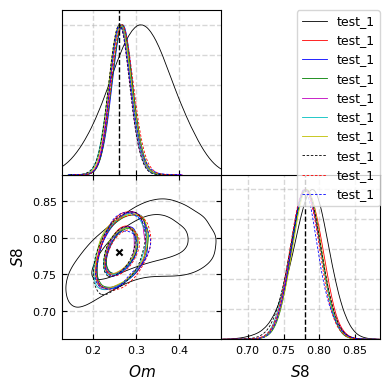

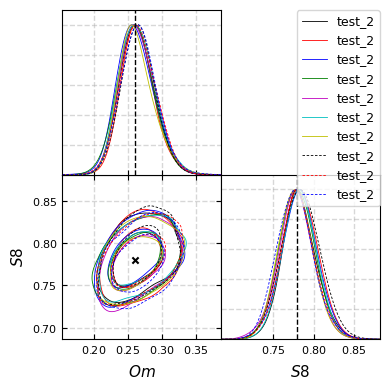

In [7]:
%matplotlib inline 

for config in config_list:
    get_and_plot_FoM(config)

# CCA dv

In [8]:
cca_file = np.load('/pscratch/sd/m/minsu98/shared_KZ/compressed_by_cca.pkl',allow_pickle=True)

compressed_dv_sims = cca_file['WL_23_WPH_short_CMBWL']['DV']
compressed_dv_labels = cca_file['WL_23_WPH_short_CMBWL']['params']

compressed_dv_fid  = cca_file['WL_23_WPH_short_CMBWL']['target']

compressed_dv_fid = compressed_dv_fid.reshape(-1,1).T

# Only infer Omm and S8

compressed_dv_labels = compressed_dv_labels[:,0:2]


/tmp/ipykernel_208442/2078060272.py:11: DeprecationWarning: This method is deprecated and will be removed in a future release.Please use `from sbi.neural_nets import posterior_nn` in the future.
  inference = SNPE(prior=prior, density_estimator=sbi.utils.posterior_nn(\


 Neural network successfully converged after 75 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Removed no burn in
 Neural network successfully converged after 73 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Removed no burn in
 Neural network successfully converged after 42 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Removed no burn in
 Neural network successfully converged after 70 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Removed no burn in
 Neural network successfully converged after 53 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Removed no burn in
 Neural network successfully converged after 58 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Removed no burn in
 Neural network successfully converged after 53 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Removed no burn in
 Neural network successfully converged after 85 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Removed no burn in
 Neural network successfully converged after 64 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Removed no burn in
 Neural network successfully converged after 40 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Removed no burn in
FoM in test 0 is 2191.373660572578
FoM in test 1 is 2189.1313629665547
FoM in test 2 is 1749.6017506932526
FoM in test 3 is 2130.214973843131
FoM in test 4 is 1839.0817151694146
FoM in test 5 is 2011.894595811427
FoM in test 6 is 2076.5919794048077
FoM in test 7 is 1904.1986556327938
FoM in test 8 is 2013.7095512727167
FoM in test 9 is 1713.574074789235
mean FoM is  1981.9372320155912


/tmp/ipykernel_208442/2078060272.py:11: DeprecationWarning: This method is deprecated and will be removed in a future release.Please use `from sbi.neural_nets import posterior_nn` in the future.
  inference = SNPE(prior=prior, density_estimator=sbi.utils.posterior_nn(\


 Neural network successfully converged after 41 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Removed no burn in
 Neural network successfully converged after 47 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Removed no burn in
 Neural network successfully converged after 44 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Removed no burn in
 Neural network successfully converged after 51 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Removed no burn in
 Neural network successfully converged after 45 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Removed no burn in
 Neural network successfully converged after 75 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Removed no burn in
 Neural network successfully converged after 58 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Removed no burn in
 Neural network successfully converged after 44 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Removed no burn in
 Neural network successfully converged after 46 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Removed no burn in
 Neural network successfully converged after 50 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Removed no burn in
FoM in test 0 is 2015.2945738666238
FoM in test 1 is 1782.509489777163
FoM in test 2 is 2338.4938970151647
FoM in test 3 is 1847.0377704888192
FoM in test 4 is 2161.3057192690953
FoM in test 5 is 2002.925300443684
FoM in test 6 is 2027.0290073052481
FoM in test 7 is 1884.6885299160235
FoM in test 8 is 1762.4311011046013
FoM in test 9 is 2155.7751534923514
mean FoM is  1997.7490542678775


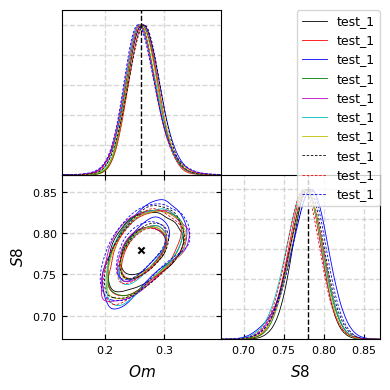

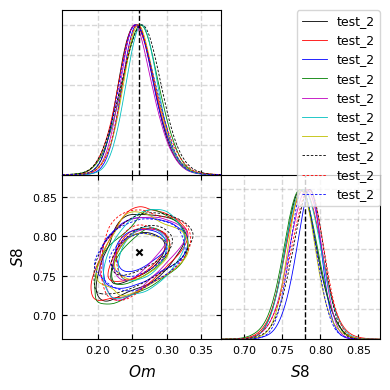

In [9]:
%matplotlib inline 

for config in config_list:
    get_and_plot_FoM(config)